# Modeling for Environmental data<br>

## * Modeling 진행 과정
    1. Preprocessing
        - Data의 변수 확인(분포확인, 연속형 변수끼리 plot)
        - 연속형 Data scaling
    2. Model selection
        - 머신러닝 모형 (rf & bart)
            - k-fold를 활용하여 hyper parameter tuning
                - 기준은 만들어낸 지표 4개로 평균화
                - 가장 best한 hyper parameter 선택하여 fitting 진행
            - train and test set에 대해 k-fold를 활용하여 performance check
        - 회귀모형 (Multinomial Logistic regression & ordinal logistic regression)
            - train and test set에 대해 k-fold를 활용하여 performance check
    3. Model select
        - 해당 팀에서 제시한 4가지 지표를 이용하여 model select
    4. Model Fitting
        - Model fitting
            - train set (661개) 모두 사용
            - 모든 train set으로 data scaling 진행
        - 선택한 모형에 대해 가정 검정
            - VIF (multicollinearity)
            - variable selection
        - 결과 해석
            - 결과 해석 및 visualization
    5. Estimation
        - fitting한 모형을 이용. GRADE를 estimate
        - variable들에 대해 train에 fitting한 function 사용하여 transform
    

## 0. Install packages and specify functions
#### Install packages

In [235]:
!pip install xbart

In [11]:
#기본적인 packages 
import pandas as pd
import numpy as np
import os 
import copy
import time
import statistics as st

#split train and test set package
from sklearn.model_selection import train_test_split

#modling packages
from sklearn.ensemble import RandomForestClassifier #RF
from xbart import XBART #xbart : c++ microsoft 설치 필요 : requirement 참조 바람
import statsmodels.api as sm #MLR
from statsmodels.miscmodels.ordinal_model import OrderedModel #OLR


#for testing
from scipy.stats import shapiro #shapiro test(정규성)
from scipy.stats import skew, kurtosis #왜도, 첨도 관련 패키지
from sklearn.preprocessing import QuantileTransformer #transformation
from sklearn.preprocessing import StandardScaler #standardscaler
from scipy.stats import bartlett #등분산성 test
import scipy.stats
from statsmodels.stats.outliers_influence import variance_inflation_factor #VIR

#for perfromance check
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#K-fold packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

##plot packages
import matplotlib.pyplot as plt
import matplotlib
from pandas.plotting import scatter_matrix
import platform
import seaborn as sns

## data directory 설정
os.chdir("C:/Users/user/Desktop/ESG데이터")

#### specify functions
- performance를 판단하는 지표에 대한 자세한 설명은 G_FinalModeling에 있으므로 생략
- confusion matrix를 만들어주는 function : make_confusionmatrix
    - social data와 environment data의 경우, Grade 1에 대한 수가 현저히 적다. 그로 인해 모델 선택에서 층화추출을 했을 때, test set에 Grade 1이 들어있지 않는 경우가 발생한다. 이때 confusion matrix는 9x9 행렬이 아닐 수 있기 때문에 따로 function을 만들어 confusion matrix가 9x9가 되도록 했다.
- multinomial logistic regression에 대한 function
    1) 모델링 후 summary 결과에 대해 회귀계수만 출력하는 function
    2) 모델링 후 marginal summary 결과에 대해 회귀계수만 출력하는 function
    3) 모델링 후 summary 결과에 대해 p-value만 출력하는 function
    4) 모델링 후 marginal summary 결과에 대해 p-value만 출력하는 function

In [12]:
#### performance를 판단하는 지표 4가지

#arg 설명
##m : confusion matrix 

#1. accuracy 계산 function
def acc(m) :
    return sum(np.diag(m))/np.sum(m)

#2. 근접정확도 계산 function
def nearest_acc(m) :
    total_sum = np.sum(m)
    near_sum = 0
    for i in range(8) :
        near_sum += m[i,i+1] + m[i+1,i]
    diag_sum = sum(np.diag(m))
    return (near_sum + diag_sum) / total_sum

#3. 과소적합/오류비 계산 function
def under_est(m) :
    error_sum = np.sum(m) - sum(np.diag(m))
    under_sum = 0
    for i in range(8) :
        under_sum += np.sum(m[i,(i+1):9])
    return under_sum / error_sum

#4. 3등급 이상 과적합/오류비 function
def over3_est(m) :
    total_sum = np.sum(m)
    error_sum = np.sum(m) - sum(np.diag(m))
    over3C_sum = 0
    for i in range(8) :
        over3C_sum += m[i,i+1] + m[i+1,i]
    for i in range(7) :
        over3C_sum += m[i,i+2] + m[i+2,i]
    diag_sum = sum(np.diag(m))
    return (total_sum - (over3C_sum + diag_sum)) / error_sum

#전체 performance 지표를 출력하는 function
def eval_stat(m) :
    print("정확도 : ",round(acc(m) * 100,2),"%")
    print("근접정확도 : ",round(nearest_acc(m) * 100,2),"%")
    print("과소적합/오류 비 : ",round(under_est(m) * 100,2),"%")
    print("3등급이상과적합/오류 비 : ",round(over3_est(m) * 100,2),"%")
    

#multinomial logistic regression에서 전체 summary에 대한 회귀계수 값을 가져오는 function  
#arg 설명
##cmodel = model.fit (이때 model은 MNLogit 모형)
def check_beta(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b[0:2]
    k = b.shape[1]/8
    ind=[]
    m_table = pd.DataFrame(index=range(0,8), columns=b.loc[0,1:(k-1)])
    for i in range(8) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table

#multinomial logistic regression에서 marginal summary에 대한 회귀계수 값을 가져오는 function 
def check_beta_mar(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b[0:2]
    k = b.shape[1]/9
    ind=[]
    m_table = pd.DataFrame(index=range(0,9), columns=b.loc[0,1:(k-1)])
    for i in range(9) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table

#multinomial logistic regression에서 전체 summary에 대한 p-value 값을 가져오는 function  
def check_p_value(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b.loc[[0,4],:]
    b.reset_index(drop=True, inplace=True)
    k = b.shape[1]/8
    m_table = pd.DataFrame(index=range(0,8), columns=b.loc[0,1:(k-1)])
    ind=[]
    for i in range(8) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table

#multinomial logistic regression에서 marginal summary에 대한 p-value 값을 가져오는 function  
def check_p_value_mar(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b.loc[[0,4],:]
    b.reset_index(drop=True, inplace=True)
    k = b.shape[1]/9
    m_table = pd.DataFrame(index=range(0,9), columns=b.loc[0,1:(k-1)])
    ind=[]
    for i in range(9) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table


#confusion matrix를 만들어주는 function
#arg 설명
## real : 참값 , pred : 예측값
def make_confusionmatrix(real, pred) :
    mat = pd.DataFrame(index=range(0,9))
    for i in range(0,9):
        b = pd.Series(np.array([0]*9))
        mat = pd.concat([b,mat], axis=1)

    real.reset_index(drop=True, inplace=True)
    pred = pd.Series(pred)
    pred_mat = pd.concat([real,pred],axis=1)
    pred_mat.columns=['real','pred']
    pred_mat = pd.crosstab(pred_mat.real, pred_mat.pred)
    real_ind = pred_mat.index.astype('int')-1
    pred_ind = pred_mat.columns.astype('int')-1

    for i in range(pred_mat.shape[0]):
        for j in range(pred_mat.shape[1]):
            mat.iloc[real_ind[i],pred_ind[j]] = pred_mat.iloc[i,j]
    mat = np.array(mat)
    return(mat)


#### 데이터 불러오기 및 정보 확인

In [13]:
df = pd.read_excel("E_final.xlsx")
data = copy.deepcopy(df)

#### 변수들의 type을 알맞게 변환
object type으로 변경해야 할 변수 존재<br>
종목코드, CDP참여, 녹색기업, ISO14001, 환경마크인증, ESG채권, 지가경발간, 지가경공시, 환경이사

In [14]:
## object에 해당하는 변수들 변경
chang_var = ['종목코드', 'CDP참여', '녹색기업', 'ISO14001', '환경마크인증',
             'ESG채권',  '지가경발간', '지가경공시', '환경이사']
data[chang_var]=data[chang_var].astype('object')

## preprocessing을 위한 train and test set 분리
print(data['E_GRADE'].unique())
train = data.loc[data['E_GRADE']!=0,]
test = data.loc[data['E_GRADE']==0,]

# index 초기화 하기
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
# print(train.shape, test.shape)

[1 2 3 4 5 6 7 8 9 0]


## 1. Preprocessing

#### num_var과 categ_var 이름 할당

In [15]:
# 그래프에서의 한글 깨짐 제거
if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    matplotlib.rc('font', family='AppleGothic')
else: #linux
    matplotlib.rc('font', family='NanumGothic')

    
# categorical variable과 numeric variable의 colname을 저장
categ_var= [var for var in train.columns if train[var].dtype=='object']
num_var= [var for var in train.columns if train[var].dtype!='object']
categ_var = categ_var[3:-1] # CDP참여 ~ 환경이사
num_var = num_var[1:] # 용수증감률 ~ E_risk

#### 변수간의 관계 - plot

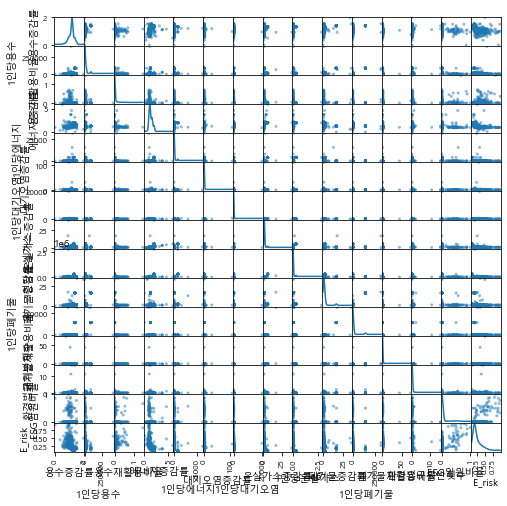

C:\Users\user\AppData\Local\Temp\ipykernel_19212\3237136908.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['E_GRADE'] = train['E_GRADE'].astype('object')
C:\Users\user\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


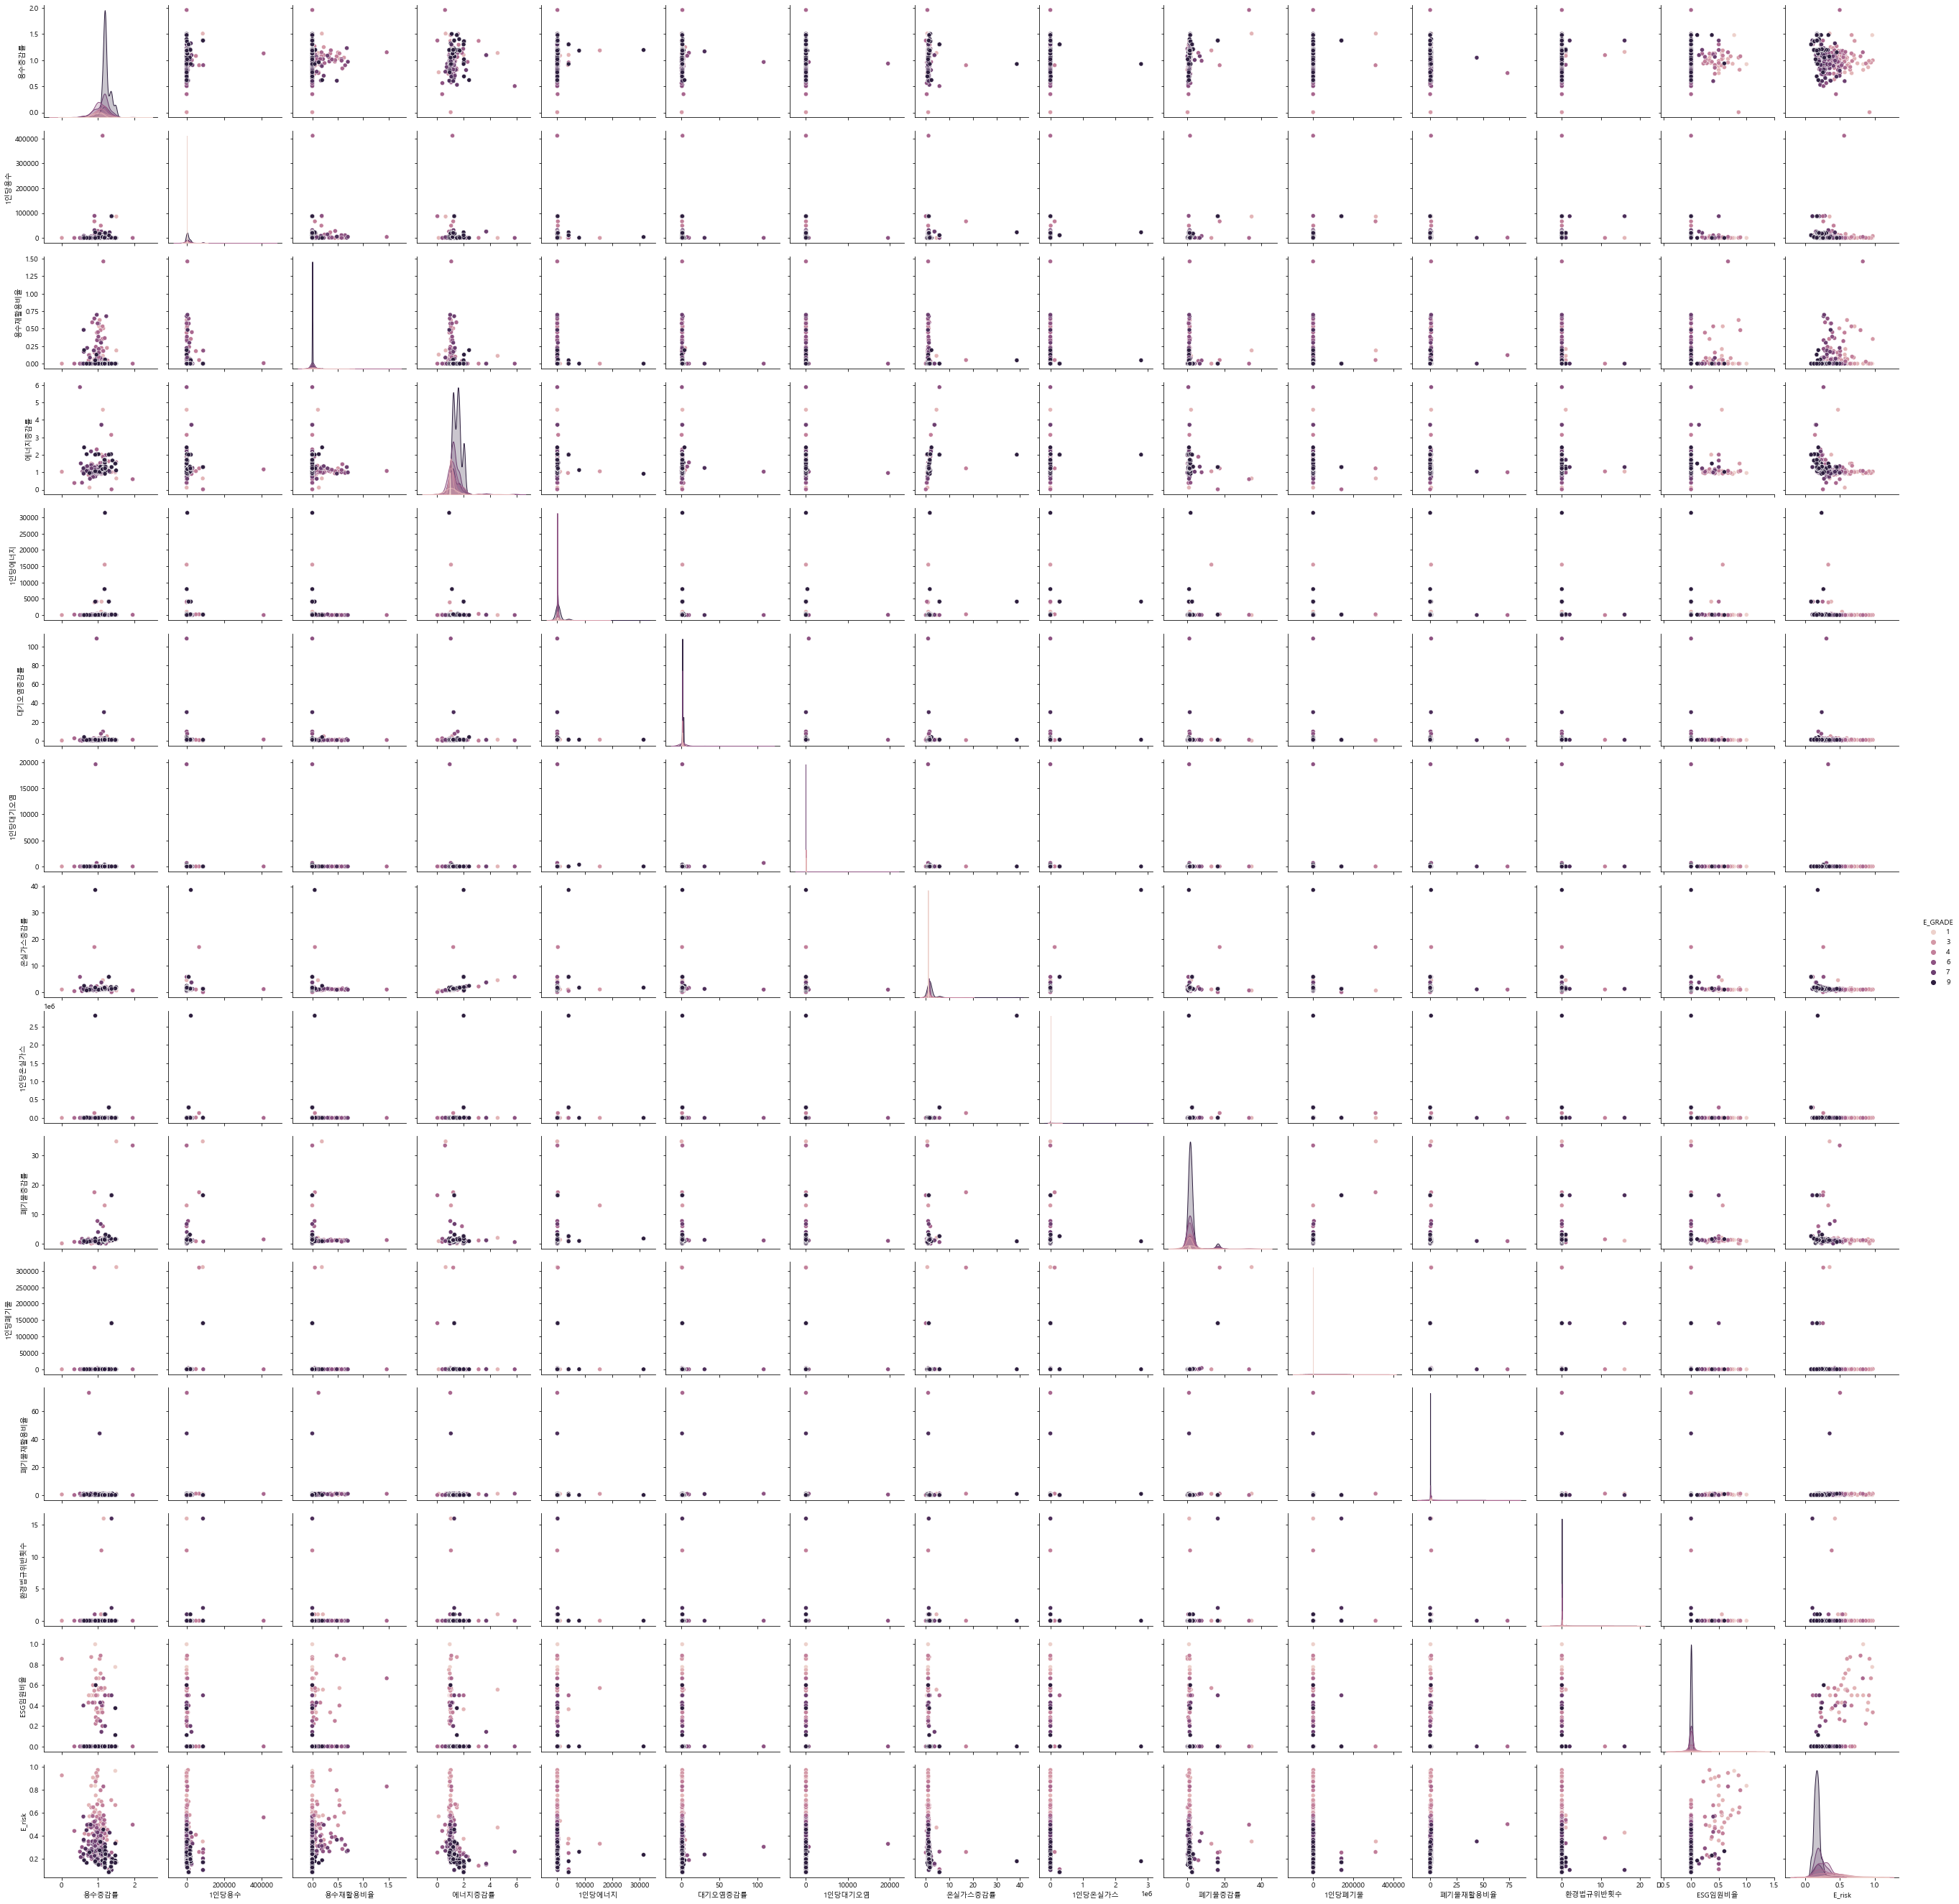

C:\Users\user\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


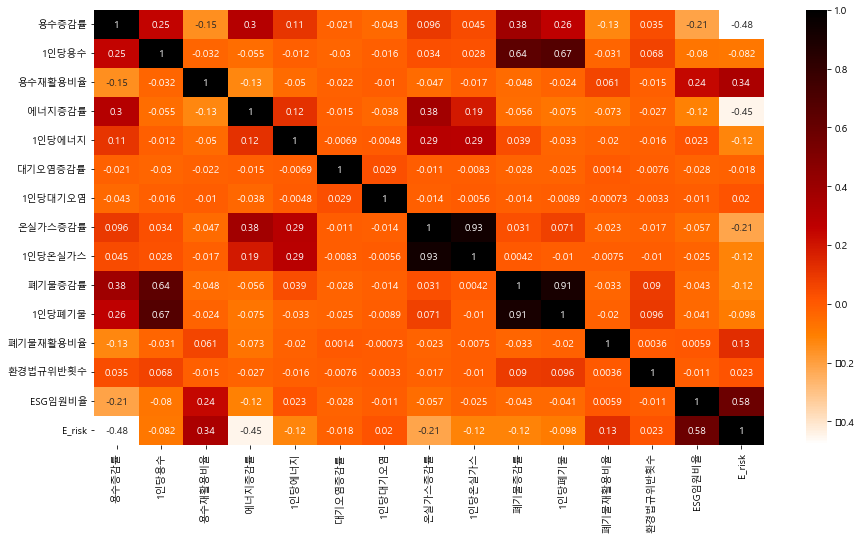

In [16]:
# 산점도 행렬 출력
scatter_matrix(train.drop(columns=['E_GRADE'], inplace=False), alpha=0.5, figsize=(8,8), 
               diagonal='kde')
plt.show()

# 산점도 행렬을 E_GRADE의 범주에 따라 그림
p_data = train[num_var]
p_data['E_GRADE'] = train['E_GRADE'].astype('object')
sns.pairplot(p_data, diag_kind='auto', hue='E_GRADE')
plt.show()

# 상관계수 행렬 그래프 : 연속 vs. 연속
p_data = p_data.drop(columns='E_GRADE').corr(method='pearson')
sns.heatmap(p_data, xticklabels=p_data.columns, yticklabels=p_data.columns,
           annot=True,cmap='gist_heat_r')
plt.show()


첫 번째 plot을 봤을 때, 용수증감률은 정규분포의 형태를 띄고 있고, E_risk도 정규분포와 유사한 종 모양을 가지고 있다. 하지만 대부분의 변수들이 왼쪽으로 심각하게 치우쳐져 있는 모습이 보인다. 따라서 모형에 잘못된 정보를 줄 가능성이 높아 보인다.   
  
 두 번째 plot을 보면 대부분의 그래프들이 왼쪽으로 심하게 치우쳐 분포의 느낌보다는 한 점에 엄청난 확률을 부여하는 막대기 같은 모습이다.  
   
  세 번째 plot은 x변수들의 correlation값을 heatmap으로 나타낸 것이다. 대부분 유의미한 상관계수를 가지고 있지 않지만 (1인당온실가스, 온실가스증감률 : 0.93), (1인당폐기물, 폐기물증감률 : 0.91) 이 두 쌍이 심각한 상관관계를 보이고, (1인당용수, 1인당폐기물 : 0.67), (1인당용수, 폐기물증감률 : 0.64) 이 두 쌍은 어느 정도의 상관관계를 보인다. 따라서 다중공선성이 우려된다.

#### 데이터의 정규성 검정 및 수치 확인

In [17]:
# 연속형 데이터의 정규성을 검정하기 위해 shapiro test 진행
## p-value가 굉장히 작음 -> H0(정규성 충족) 기각
## 따라서 해당 데이터의 연속형 변수들은 정규성을 만족하지 못하므로 transformation이 필요.
for var in num_var :
    shapiro_test = shapiro(train[var])
    print(var, shapiro_test)

print(' ')

# 왜도 : 분포의 비대칭도
print("왜도는")
pd.DataFrame(skew(train[num_var]), index=num_var).T

용수증감률 ShapiroResult(statistic=0.9272980093955994, pvalue=2.3475308029277345e-17)
1인당용수 ShapiroResult(statistic=0.3824666142463684, pvalue=1.9856399239482658e-42)
용수재활용비율 ShapiroResult(statistic=0.268393874168396, pvalue=7.006492321624085e-45)
에너지증감률 ShapiroResult(statistic=0.7743126153945923, pvalue=3.5442151496501466e-29)
1인당에너지 ShapiroResult(statistic=0.18573307991027832, pvalue=0.0)
대기오염증감률 ShapiroResult(statistic=0.07115846872329712, pvalue=0.0)
1인당대기오염 ShapiroResult(statistic=0.01843428611755371, pvalue=0.0)
온실가스증감률 ShapiroResult(statistic=0.24594491720199585, pvalue=2.802596928649634e-45)
1인당온실가스 ShapiroResult(statistic=0.10241007804870605, pvalue=0.0)
폐기물증감률 ShapiroResult(statistic=0.3490515351295471, pvalue=3.4051552683093055e-43)
1인당폐기물 ShapiroResult(statistic=0.22720122337341309, pvalue=1.401298464324817e-45)
폐기물재활용비율 ShapiroResult(statistic=0.06453275680541992, pvalue=0.0)
환경법규위반횟수 ShapiroResult(statistic=0.05545920133590698, pvalue=0.0)
ESG임원비율 ShapiroResult(statistic=0.307

,용수증감률,1인당용수,용수재활용비율,에너지증감률,1인당에너지,대기오염증감률,1인당대기오염,온실가스증감률,1인당온실가스,폐기물증감률,1인당폐기물,폐기물재활용비율,환경법규위반횟수,ESG임원비율,E_risk
0,-0.820548,7.8325,6.508321,3.219089,12.856363,22.633769,25.5946,14.061896,18.713616,4.486917,4.908116,19.272891,14.843273,3.822895,1.968477


In [18]:
# 첨도 : 분포의 뾰족한 정도
print("첨도는")
pd.DataFrame(kurtosis(train[num_var], fisher=True), index=num_var).T

첨도는


,용수증감률,1인당용수,용수재활용비율,에너지증감률,1인당에너지,대기오염증감률,1인당대기오염,온실가스증감률,1인당온실가스,폐기물증감률,1인당폐기물,폐기물재활용비율,환경법규위반횟수,ESG임원비율,E_risk
0,3.207429,103.859675,58.016154,24.272738,221.055964,542.702594,654.017814,262.97789,418.066738,22.62577,26.856831,388.695568,226.059808,14.563492,4.51759


raw data에 대한 plot과 더 정확한 정규성 검정을 위한 shapiro test, 왜도, 첨도값을 출력했다. 각 값들의 의미는 G_FinalModeling에 있으므로 생략한다.  
plot에서 볼 수 있듯이 shapiro test 결과 E_data에 사용된 numeric variable은 모두 정규성을 만족하지 않는다. 또한 용수증감률을 제외한 나머지 왜도가 0보다 크고, 그 값 또한 0과 멀다. 즉, 대부분의 변수들이 왼쪽으로 치우친 모습을 보인다. 특히 1인당 에너지, 대기오염증감률, 1인당 대기오염 등 많은 경우에서 높은 왜도값을 가진다. 첨도는 모든 변수에서 0보다 큰 값으로 정규분포보다 뾰족한 분포를 따른다고 할 수 있다. 특히 1인당용수, 1인당에너지, 대기오염증감률, 1인당대기오염 등 대부분의 환경관련 데이터의 첨도가 아주 심하게 큰 것을 알 수 있다.  


#### 데이터 Scaling using Quantile Transformation
- 위 결과를 통해서 해당 변수들에게 scaling을 해줘야 한다는 insight를 얻을 수 있었다. Quantile Transformation에 대한 자세한 설명은 G_FinalModeling에 있으므로 생략하도록 하겠다.

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (661). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


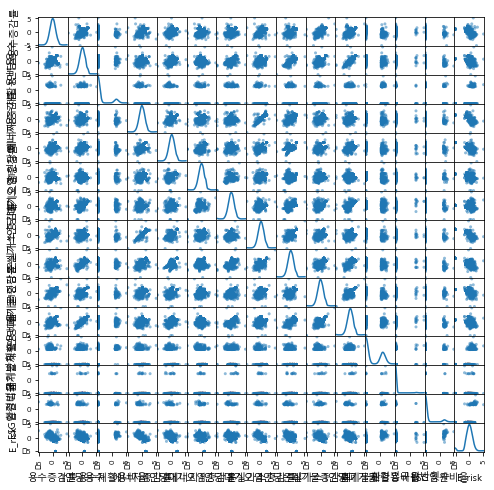

C:\Users\user\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


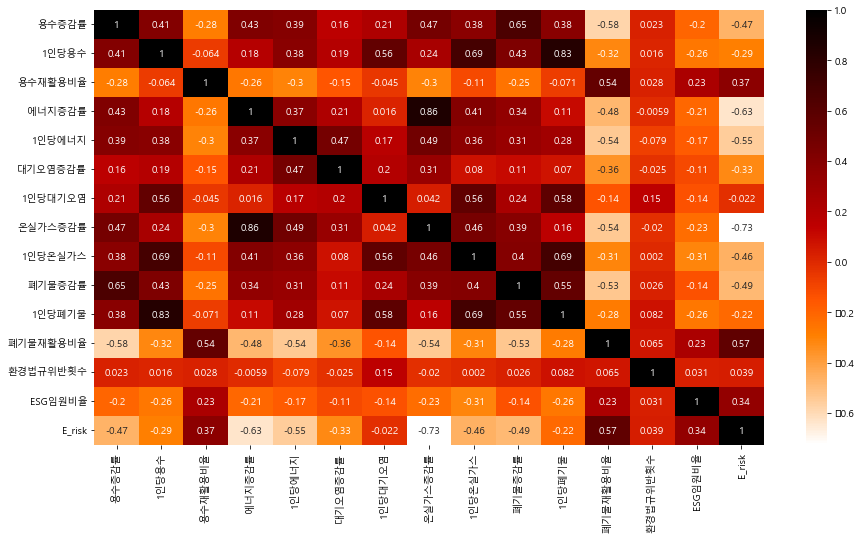

정규성 검정
용수증감률 ShapiroResult(statistic=0.9860072135925293, pvalue=5.830486315971939e-06)
1인당용수 ShapiroResult(statistic=0.9826584458351135, pvalue=4.64735194327659e-07)
용수재활용비율 ShapiroResult(statistic=0.42939293384552, pvalue=2.7052066853790594e-41)
에너지증감률 ShapiroResult(statistic=0.9860557913780212, pvalue=6.0611341723415535e-06)
1인당에너지 ShapiroResult(statistic=0.9834372401237488, pvalue=8.166829275069176e-07)
대기오염증감률 ShapiroResult(statistic=0.9665011763572693, pvalue=3.799063147402748e-11)
1인당대기오염 ShapiroResult(statistic=0.9705758690834045, pvalue=2.9568805737234527e-10)
온실가스증감률 ShapiroResult(statistic=0.9846764206886292, pvalue=2.062976591332699e-06)
1인당온실가스 ShapiroResult(statistic=0.9841285347938538, pvalue=1.3631786259793444e-06)
폐기물증감률 ShapiroResult(statistic=0.9774143695831299, pvalue=1.4365152622985988e-08)
1인당폐기물 ShapiroResult(statistic=0.9759860634803772, pvalue=6.052484291529936e-09)
폐기물재활용비율 ShapiroResult(statistic=0.6462477445602417, pvalue=8.966690997087194e-35)
환경법규위반횟수 Shapi

,용수증감률,1인당용수,용수재활용비율,에너지증감률,1인당에너지,대기오염증감률,1인당대기오염,온실가스증감률,1인당온실가스,폐기물증감률,1인당폐기물,폐기물재활용비율,환경법규위반횟수,ESG임원비율,E_risk
0,-0.027793,-0.060097,2.087436,-0.021496,-0.048319,-0.331225,-0.292615,-0.04507,-0.056569,-0.188398,-0.201069,0.713135,7.132491,3.064612,-1.603689


In [19]:
qt = QuantileTransformer(output_distribution='normal')
qt.fit(train[num_var])
train[num_var] = qt.transform(train[num_var])
test[num_var] = qt.transform(test[num_var])

scatter_matrix(train[num_var], alpha=0.5, figsize=(8,8), diagonal='kde')
plt.show()

# 상관계수 행렬 그래프 : 연속 vs. 연속
train_corr = train[num_var].corr(method='pearson')
plt.figure(figsize = (15,8))
sns.heatmap(train_corr, xticklabels=num_var, yticklabels=num_var,
           annot=True,cmap='gist_heat_r')
plt.show()

print("정규성 검정")
for var in num_var :
    shapiro_test = shapiro(train[var])
    print(var, shapiro_test)

print("왜도는")
pd.DataFrame(skew(train[num_var]), index=num_var).T

In [20]:
print("첨도는")
pd.DataFrame(kurtosis(train[num_var], fisher=True), index=num_var).T

첨도는


,용수증감률,1인당용수,용수재활용비율,에너지증감률,1인당에너지,대기오염증감률,1인당대기오염,온실가스증감률,1인당온실가스,폐기물증감률,1인당폐기물,폐기물재활용비율,환경법규위반횟수,ESG임원비율,E_risk
0,1.418749,1.406707,2.458616,1.43373,1.419076,2.665053,2.631509,1.401019,1.372822,2.046229,2.042629,-1.407327,50.170458,7.549263,5.410651


* Scaling을 한 결과 첫 번째 plot과 같이 scaling 전보다는 몇 변수를 제외하고는 정규분포의 모양을 띄는 것을 보인다.

* 두 번째 plot은 상관계수에 관련된 것이다. scaling 하기 전 문제가 되었던 (1인당온실가스, 온실가스증감률:0.93), (1인당폐기물, 폐기물증감률:0.91) 이 두 쌍은 모두 상관계수가 줄어들었다.  (1인당용수, 폐기물증감률 : 0.64) 또한 scaling 후 상관계수가 줄어들었으나, (1인당용수, 폐기물증감률 : 0.64)의 경우 0.83으로 오히려 증가했다. 그 외에도 상관계수가 커진 쌍이 존재했다. 그는 다음과 같다. (에너지증감률, 온실가스증감률), (1인당온실가스, 1인당폐기물), (1인당용수, 1인당온실가스)

* 더 자세한 정보를 위해 test와 첨도, 왜도를 출력했다. 왜도의 경우 대부분 안정화 되었고, 0보다 훨씬 컸던 대기오염증감률(22), 1인당대기오염(25), 1인당온실가스(18) 의 경우 많이 줄어들었다. 그리고 654에 육박해 심각하던 1인당대기오염의 첨도가 2.631509로 안정화 되었고, 그 외 대기오염증감률이나 1인당온실가스의 경우도 그 전 값에 비해서는 훨씬 안정화된 모습이다.  정규성을 가설검정으로 보장하지는 않지만 첨도와 왜도가 어느 정도 줄어들었고, 더 이상의 변환은 데이터에 불필요한 보정을 할 수 있어 하지 않았다. 

In [21]:
## dummy variable을 위해 scaling한 데이터를 다시 합침
total_data = pd.concat([train, test], ignore_index=True)

####  object type 변수들에 대해서 dummy variable 생성
- 자세한 설명은 G_FinalModeling에 있으므로 생략한다.

In [22]:
# linear regression용 data의 경우 multicollinearity를 예방하기 위해 categorical variable에서 
# category의 개수가 3이상인 경우, 마지막 변수를 제거. : 그런 경우 없음.
# print("The value counts are")
# for var in categ_var :
#     print(total_data[var].value_counts())  
print("Variables have more than three levels")
for var in categ_var :
    if len(total_data[var].unique()) >= 3 :
        print(var, end=', ')
        
# regression용 data
rdata = copy.deepcopy(total_data)

# binary variable들을 다시 int type으로 변경(굳이 dummy로 만들 필요 없음)
chan_var = [var for var in rdata.columns if rdata[var].dtype == 'object']
chan_var = chan_var[3:-1]

rdata[chan_var] = rdata[chan_var].astype('int')

## machinelearning용 data -> object를 factor화
mdata = copy.deepcopy(total_data)
object_columns = mdata.dtypes[mdata.dtypes == 'object'].index.tolist()

for column in object_columns[3:-1]:
    mdata[column] = pd.factorize(mdata[column])[0]     

Variables have more than three levels


C:\Users\user\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


#### rdata와 mdata를 train과 test set으로 분리.

In [23]:
r_train = rdata.loc[rdata['E_GRADE']!=0,]
r_test = rdata.loc[rdata['E_GRADE']==0,]
m_train = mdata.loc[rdata['E_GRADE']!=0,]
m_test = mdata.loc[rdata['E_GRADE']==0,]

# index를 reset
r_train = r_train.reset_index(drop=True)
r_test = r_test.reset_index(drop=True)
m_train = m_train.reset_index(drop=True)
m_test = m_test.reset_index(drop=True)

## 2. Model Selection
- 머신러닝에서 2개의 모델, 회귀분석에서 2개의 모델 총 4개의 모델을 이용하여 당사에서 제공한 참값이 입력되어 있는 train set을 이용하여 다시 train과 test로 나누어서 hyperparameter tuning 및 예측 결과를 비교하려 한다. 
* 이때 분석 데이터는 업종별, 등급별로 층을 나누어 분포한 데이터라고 생각되어 층화추출을 이용하여 train과 test set을 나누었다.

### 2-1. RandomForest : m_train 사용
    * 목차
        - hyper parameter setting (using cross validation)
        - modeling (using k-fold)
        - performance check

- 특징
    - 데이터가 적더라도 반복 학습, 검증을 통해 overfitting을 방지
    - 상대적으로 튜닝이 거의 필요 없음
    - variable importance를 통해 어느 정도 변수에 대한 설명 가능

#### hyper parameter tuning
- 머신러닝에서 hyperparameter를 tuning하기 위해 여러가지 parameter 선택 값과 cross validation을 사용하였다. 이때 cross-validation의 값은 5를 사용했다.

In [24]:
## parameter tuning
# n_estimator : 트리의 개수. default는 10, 많을수록 성능이 좋아질 수 있으나 항상 그런 건 아님.
# max_depth : 트리의 깊이
# min_samples_leaf : leaf node가 되기 위한 최소한의 샘플 데이터 수
# min_samples_split : 노드를 분할하기 위한 최소한의 데이터 수

n_estimators = [50,100,200,300,400,500,700]
max_depth = [6,8,10,12]
min_samples_leaf = [3,5,7,10]
min_samples_split = [3,5,7,10]

## K-Fold
y = m_train['E_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)

# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
best_hype = []
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []

for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # hyperparameter 조합에 따라서 반복
    for i in range(len(n_estimators)) :
        print(i, end='')
        for j in range(len(max_depth)) :
            for k in range(len(min_samples_leaf)) :
                for l in range(len(min_samples_split)) :
                    model = RandomForestClassifier(max_depth=max_depth[j], 
                                                   min_samples_leaf=min_samples_leaf[k],
                                                   min_samples_split=min_samples_split[l],
                                                   n_estimators=n_estimators[i], 
                                                   random_state=10)
                    model.fit(x_train, y_train)
                    y_pred = model.predict(x_test) # 예측 라벨
                    m = make_confusionmatrix(y_test, y_pred)
                    acc_vec.append(acc(m)) 
                    nearest_acc_vec.append(nearest_acc(m))
                    under_est_vec.append(under_est(m))
                    over3_est_vec.append(over3_est(m))
                    hype = [n_estimators[i],max_depth[j],min_samples_leaf[k],min_samples_split[l]] #제일 좋은 hyperparameter를 얻기 위해 hype에 할당
                    best_hype.append(hype)
                    
# hyperparameter들의 결과를 출력 및 저장
hype = pd.DataFrame(best_hype, columns=['ne', 'md', 'ml', 'ms'])
rf_hype = pd.DataFrame({'정확도':acc_vec, '근접정확도':nearest_acc_vec,
                       '과소추정오류비':under_est_vec, '3단계과추정률':over3_est_vec})

rf_hype = pd.concat([hype, rf_hype], axis=1)
rf_hype_mean = rf_hype.groupby(['ne', 'md', 'ml', 'ms'], as_index=False).mean()
print(rf_hype_mean.sort_values('정확도',ascending=False).head(1))

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


01234560123456012345601234560123456   ne  md  ml  ms       정확도     근접정확도   과소추정오류비   3단계과추정률
2  50   6   3   7  0.381773  0.653839  0.697199  0.210499


* 위의 값이 가장 accuracy가 좋았던 hyperparameter 값이다. 이에 따라 해당 값으로 random forest 모형 fitting을 진행했다.

#### K-fold를 활용한 fitting 및 performance 출력

In [15]:
## set hyperparameter 
sel = rf_hype_mean.sort_values('정확도',ascending=False).head(1)
ne=sel.iloc[0,0] #n_estimators
md=sel.iloc[0,1] #max_depth
ml=sel.iloc[0,2] #min_samples_leaf
ms=sel.iloc[0,3] #min_samples_split


## K-Fold를 통한 randomforest fitting
y = m_train['E_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)

# split 개수, 셔플 여부 및 seed 설정 / 5-fold 진행
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time() 
for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # hyper parameter tuning의 결과
    model = RandomForestClassifier(n_estimators=ne, max_depth=md, min_samples_leaf=ml,
                                  min_samples_split=ms)
    model.fit(x_train, y_train) # 모델 학습

    y_pred = model.predict(x_test) # 예측 라벨
    m = make_confusionmatrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))
    
print("time :", time.time() - start)
print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 1.8104097843170166
정확도: [38.35 53.03 47.73 46.97 43.18]     정확도 평균: 45.85
근접정확도: [64.66 73.48 63.64 70.45 66.67]     근접정확도 평균: 67.78
과소추정오류비: [70.73 77.42 79.71 62.86 69.33]     과소추정오류비 평균: 72.00999999999999
3단계과추정률: [25.61 25.81 31.88 25.71 22.67]     3단계과추정률: 26.340000000000003


* Random Forest의 결과는 위와 같다. 소요시간은 1.81초 이다. 
* 각 정확도와 근접정확도, 과소추정오류비, 그리고 3단계과추정률은 위의 값과 같다.
* 각 지표의 평균 값은 각 정확도, 근접정확도, 과소추정오류비, 3단계과추정률 순으로 45.85%, 67.78%, 72.01%, 26.34%이다.

### 2-2. XBART : m_train 사용 
     * 목차
    - hyper parameter setting (using cross validation)
    - modeling (using k-fold)
    - performance check
    
- 특징 및 설명
    - Bayesian Additive Regression Tree 방식
    - Bayesian방식으로 additive regression tree를 사용한 모델로 prior를 선택할 수 있는 것이 큰 특징
    - tree 모형과 마찬가지로 예측에 있어서 logic을 가지고 있기 때문에 classification에 대한 논리 설명 가능
    - variable importance를 통해 어느 정도 변수에 대한 설명 가능
    - 속도가 느리고 mcmc mixing이 다소 느릴 수 있다는 게 단점

#### hyper parameter tuning

In [ ]:
## parameter tuning
# parameter에 대한 설명
# num_trees : 각 반복에서의 트리의 개수, default=100
# num_sweeps : MCMC 반복 수, default=40
# n_min : 각 final node에서 sample의 최소 개수
# alpha, beta : tree prior hyperparameter : alpha*(1+depth)^beta : default(0.95 / 1.25)
# kap. s : prior for sigma : default(16.0 / 4.0)

num_trees = [100,200]
num_sweeps = [100,200]
n_min = [5,7,10]


## K-Fold
y = m_train['E_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
best_hype = []
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for i in range(len(num_trees)) :
        print(i, end='')
        for j in range(len(num_sweeps)) :
            for k in range(len(n_min)) :
                model = XBART(model='Multinomial', num_classes=9, seed=10, num_trees=num_trees[i], 
                              num_sweeps=num_sweeps[j],n_min=n_min[k])
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test, return_mean=True)
                y_pred = y_pred.argmax(1) + 1
                m = make_confusionmatrix(y_test, y_pred)
                acc_vec.append(acc(m))
                nearest_acc_vec.append(nearest_acc(m))
                under_est_vec.append(under_est(m))
                over3_est_vec.append(over3_est(m))
                hype = [num_trees[i],num_sweeps[j],n_min[k]]
                best_hype.append(hype)
                
                
# hyperparameter들의 결과를 출력 및 저장
hype = pd.DataFrame(best_hype, columns=['nt', 'ns', 'nm'])
bart_hype = pd.DataFrame({'정확도':acc_vec, '근접정확도':nearest_acc_vec,
                       '과소추정오류비':under_est_vec, '3단계과추정률':over3_est_vec})

bart_hype = pd.concat([hype, bart_hype], axis=1)
bart_hype_mean = bart_hype.groupby(['nt', 'ns', 'nm'], as_index=False).mean()
print(bart_hype_mean.sort_values('정확도',ascending=False).head(1))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


0

* 위의 값이 가장 accuracy가 좋았던 hyperparameter 값이다. 이에 따라 해당 값으로 bart 모형 fitting을 진행했다.

#### K-fold를 활용한 fitting 및 performance 출력

In [25]:
sel = bart_hype_mean.sort_values('정확도',ascending=False).head(1)
nt = sel.iloc[0,0] #num_trees
ns = sel.iloc[0,1] #num_sweeps
nm = sel.iloc[0,2] #n_min

## K-Fold
y = m_train['E_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time() 
for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    model = XBART(model='Multinomial', num_classes=9, seed=10, num_trees=nt, 
                              num_sweeps=ns,n_min=nm)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test, return_mean=True)
    y_pred = y_pred.argmax(1) + 1
    m = make_confusionmatrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))

print("time :", time.time() - start)
print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 435.6253888607025
정확도: [49.62 28.03 17.42  1.52  0.  ]     정확도 평균: 19.32
근접정확도: [59.4  43.94 60.61 60.61 60.61]     근접정확도 평균: 57.03
과소추정오류비: [77.61 54.74 55.96 40.   39.39]     과소추정오류비 평균: 53.54
3단계과추정률: [65.67 25.26 33.94 17.69 11.36]     3단계과추정률: 30.79


* XBART의 결과는 위와 같다. 소요시간은 471.705초 이다.
* 각 정확도와 근접정확도, 과소추정오류비, 그리고 3단계과추정률은 위의 값과 같다. 
* 각 지표의 평균 값을 정확도 19.32%, 근접정확도 57.03%, 과소추정오류비 53.54%, 3단계과추정률이 30.79%이다.

### 2-3. Multinomial Logistic Regression : r_train 사용
       * 목차
            - modeling (using k-fold)
            - performance check

- 특징 및 설명
    - 독립변수의 선형 결합을 이용하여 사건의 발생 가능성을 예측하는데 사용되는 모델
    - 종속변수가 범주형 데이터일 때를 대상으로 한 모델
    - 오즈(성공확률/실패확률)를 logit 변환한 모델
    - 통계에서 가장 기본적이면서도 powerful한 모형으로 사용자가 쉽게 사용가능
    - 머신러닝 기법과 달리 hyperparameter tuning이 필요 없음
    - 다양한 자연스러운 통계적 해석이 가능

#### K-fold를 활용한 fitting 및 performance 출력

In [16]:
## K-Fold
y = r_train['E_GRADE'] # y값 할당
new_data = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)# x값 할당(fitting에 불필요한 변수 제거)
new_data = sm.add_constant(new_data, prepend=False)# 해당 모형을 돌리기 위해 상수부분 추가
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time() 
for train_index, test_index in str_kf.split(new_data, r_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 다범주 분류에 사용되는 solver에는 newton-cg, lbfgs가 존재
    # lbfgs가 더 성능이 좋다고 알려져있음.
    # 또한 MNLogit에서는 newton-cg 방법을 지원하지 않음.
    model = sm.MNLogit(y_train, x_train) # 모델 학습
    result= model.fit(method='lbfgs', maxiter=10000)


    y_pred = model.predict(result.params, x_test) # 예측 라벨
    y_pred = y_pred.argmax(1) + 1
    m = make_confusionmatrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))
    
print("time :", time.time() - start)
print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 3.577810049057007
정확도: [39.1  50.76 47.73 49.24 40.91]     정확도 평균: 45.550000000000004
근접정확도: [60.9  69.7  61.36 73.48 66.67]     근접정확도 평균: 66.42
과소추정오류비: [64.2  64.62 75.36 65.67 64.1 ]     과소추정오류비 평균: 66.79
3단계과추정률: [29.63 27.69 28.99 22.39 21.79]     3단계과추정률: 26.1



* Multinomial Logistic Regression의 결과는 위와 같다. 소요시간은 3.57초이다. 
* 각 지표의 평균 값은 정확도는 45.55%, 근접정확도는 66.42%, 과소추정오류비는 66.79%, 3단계과추정률은 26.1% 이다.  

해당 모형에서 사용할 수 있는 solver에 관련된 설명은 G_FinalModeling에 있으므로 생략한다.

### 2-4. Ordinal Logistic Regression : r_train 사용 here
     * 목차
        - modeling (using k-fold)
        - performance check
    
- 특징 및 설명
    - 종속변수가 범주형 데이터이고 순서가 있을 때를 대상으로 한 모델
    - 머신러닝 기법과 달리 hyperparameter tuning이 필요 없음
    - 다양한 자연스러운 통계적 해석이 가능

#### K-fold를 활용한 fitting 및 performance 출력

In [17]:
## K-Fold
y = r_train['E_GRADE']
new_data = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time() 
for train_index, test_index in str_kf.split(new_data, r_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    t = pd.CategoricalDtype(categories = y_train.unique(), ordered = True)
    y_train = pd.Series(y_train, dtype = t)
    y_test = pd.Series(y_test, dtype = t)
    
    model = OrderedModel(y_train, x_train, distr = 'probit')
    result = model.fit(method='lbfgs', maxiter=10000) # 모델 학습

    y_pred = model.predict(result.params, exog = x_test) # 예측 라벨
    y_pred = y_pred.argmax(1) + 1
    m = make_confusionmatrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))

print("time :", time.time() - start)
print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 9.236597061157227
정확도: [17.29  3.03  1.52  2.27  3.03]     정확도 평균: 5.43
근접정확도: [40.6   6.06  2.27  3.79  8.33]     근접정확도 평균: 12.21
과소추정오류비: [26.36 16.41 12.31 16.28 18.75]     과소추정오류비 평균: 18.02
3단계과추정률: [17.27 94.53 95.38 96.9  92.97]     3단계과추정률: 79.41


* Ordinal Logistic Regression의 결과는 위와 같다. 소요시간은 9.23초이다. 
* 정확도는 13%-60%, 근접정확도는 54%-85%, 과소추정오류비는 60%-82%, 3단계과추정률은 17%-32%이다. 
* 각 지표의 평균 값은 정확도는 5.43%, 근접정확도는 12.21%, 과소추정오류비는 18.02%, 3단계과추정률은 79.41% 이다.

* slover에 대한 의미는 Multinomial Logistic Regression과 같다.

## 3. Model select based on performance
- Multinomial Logistic Model을 선택하게 된 논리는 G_FinalModeling에 자세하게 설명되어 있으니 생략하겠다.

## 4. Model Fitting
- 전체 모형은 cross validation 없이 train set(당사에서 제공한 참값이 있는 data set)을 사용해 적합했다.

#### 가정 검정 (multicollinearity) : VIF
- 선택한 모형에 fitting하기 전, 문제가 많이 되는 다중공선성에 대해 살펴보기 위해 VIF를 계산했다.
- VIF값은 10보다 큰 경우 다중공선성이 발생한 것으로 판단한다.

In [18]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
   r_train[num_var].values, i) for i in range(r_train[num_var].shape[1])]
vif["features"] = r_train[num_var].columns
print("### Train set VIF ###")
vif

### Train set VIF ###


,VIF Factor,features
0,2.188584,용수증감률
1,3.921095,1인당용수
2,6.053821,용수재활용비율
3,4.099389,에너지증감률
4,1.962025,1인당에너지
5,1.580388,대기오염증감률
6,2.091759,1인당대기오염
7,5.432709,온실가스증감률
8,3.739988,1인당온실가스
9,2.804802,폐기물증감률


* train set의 VIF값은 위와 같다. VIF값은 10이상일 경우 다중공선성이 발생했다고 해석할 수 있는데 모든 VIF 값이 10보다 작으므로 다중공선성의 위험은 없다.

C:\Users\USER\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


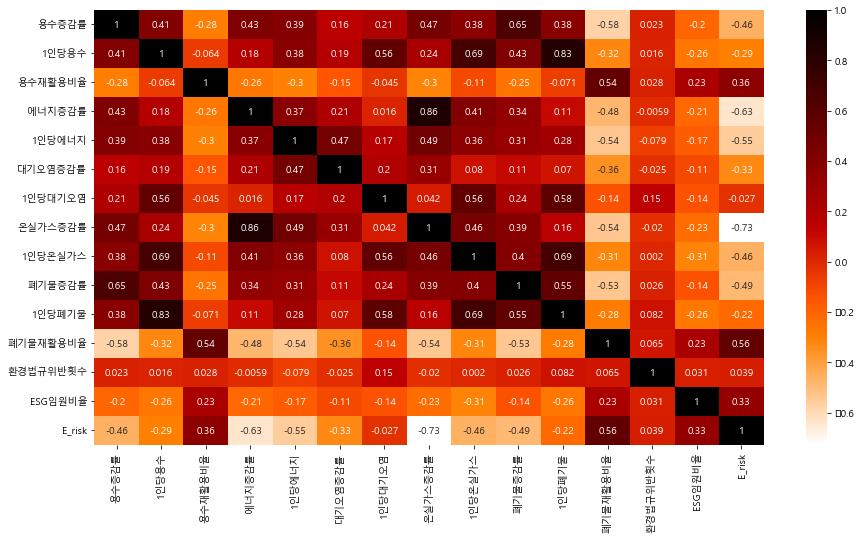

In [19]:
#correlation map
plt.figure(figsize = (15,8))
sns.heatmap(r_train[num_var].corr(), annot=True,cmap='gist_heat_r')
plt.show()

* 상관계수 plot의 결과 앞선 preprocessing 단계에서도 언급했던 1인당온실가스와 1인당용수, 1인당폐기물과 1인당용수, 에너지증감률과온실가스증감률, 1인당온실가스와 1인당폐기물간의 상관관계 문제가 존재한다. 
* 이는 추후에 variable selection을 통해서 완화될 것이라고 기대하고 있다.

#### 주어진 train data set에 대해 Model Fitting : r_train 사용

In [20]:
y_train = r_train['E_GRADE']
x_train = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)

x = sm.add_constant(x_train, prepend=False)
model = sm.MNLogit(y_train, x)#모형 할당
result = model.fit(method='lbfgs', maxiter=100000, full_output=True)#모형 적합
mar=result.get_margeff()
y_pred = model.predict(result.params, x)#모형 예측
y_pred = y_pred.argmax(1) + 1 #이때, 모형이 예측한 값은 확률값이기 때문에 이를 이용하여 classification 진행
y_pred = pd.Series(y_pred)
## 모형 fitting 결과
print("[Logistic Regression Train Set Evaluation]")
eval_stat(make_confusionmatrix(y_train, y_pred))

[Logistic Regression Train Set Evaluation]
정확도 :  53.56 %
근접정확도 :  71.1 %
과소적합/오류 비 :  71.34 %
3등급이상과적합/오류 비 :  27.04 %


* 전체 train set을 이용하여 모형을 적합한 결과 정확도는  53.56%, 근접정확도는   71.1%, 과소적합/오류비는 71.34 %, 3등급이상과적합/오류비는 27.04 % 로 나타난다.

#### result confusion matrix

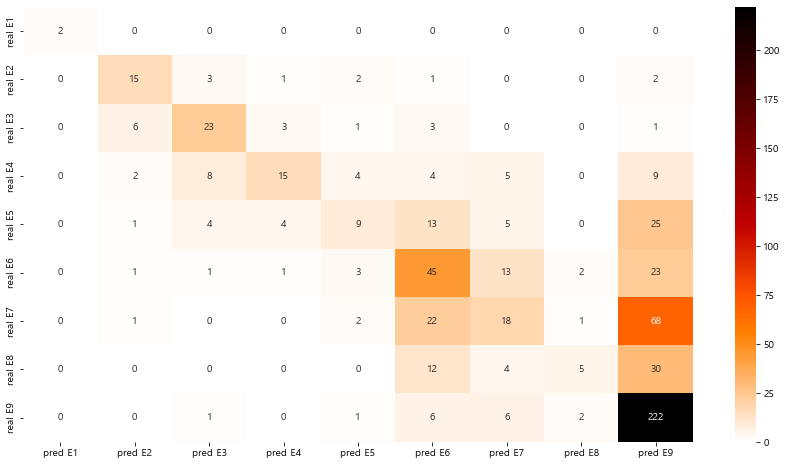

In [21]:
confmtrx = np.array(make_confusionmatrix(y_train, y_pred))
confmtrx = pd.DataFrame(confmtrx, index=['real E1','real E2','real E3','real E4','real E5','real E6','real E7', 'real E8',
                              'real E9']
             , columns=['pred E1','pred E2','pred E3','pred E4','pred E5','pred E6','pred E7','pred E8','pred E9'])

plt.figure(figsize = (15,8))
ax = sns.heatmap(confmtrx,annot=True,cmap='gist_heat_r',fmt='g')
plt.show()

#### Result 
- MLR의 해석이 어려운 특성 상 margianl summary도 결과로 출력했다. marginal summary는 전체 summary와 달리 한 등급의 오즈비에 대해 회귀계수를 출력하여 보여준다.

In [22]:
print('### print marginal summary ###')
print(mar.summary())

# Pseudo R-squ. : 맥파든 의사결정계수 : 가장 성능이 좋을 때 1이고, 나쁠 때 0
# Log-Likelihood : 모든 covariate을 넣었을 때의 likelihood 값
# LL-Null : 아무 covariate도 없을 때의 likelihood 값
# LLR p-value : 귀무가설 : Saturated model에서 추가적으로 존재하는 설명 변수의 회귀계수들은 모두 0이다.
# -> p-value가 작으므로 기각 : 해당 모형의 설명변수들의 회귀계수들은 모두 0이 아니다.

print("### print model summary ###")
print(result.summary())

### print marginal summary ###
       MNLogit Marginal Effects      
Dep. Variable:                E_GRADE
Method:                          dydx
At:                           overall
 E_GRADE=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
용수증감률       4.639e-05      0.001      0.039      0.969      -0.002       0.002
1인당용수      -3.844e-06      0.002     -0.002      0.998      -0.003       0.003
용수재활용비율    -8.045e-06      0.001     -0.015      0.988      -0.001       0.001
에너지증감률     -2.233e-05      0.003     -0.007      0.995      -0.007       0.007
1인당에너지      2.557e-05      0.001      0.027      0.979      -0.002       0.002
대기오염증감률    -1.719e-05      0.001     -0.014      0.989      -0.003       0.002
1인당대기오염     2.341e-06      0.001      0.002      0.998      -0.002       0.002
온실가스증감률    -1.346e-05      0.004     -0.003      0.997      -0.008       0.008
1인당온실가스     3.191e-05      

                          MNLogit Regression Results                          
Dep. Variable:                E_GRADE   No. Observations:                  661
Model:                        MNLogit   Df Residuals:                      469
Method:                           MLE   Df Model:                          184
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.2930
Time:                        20:47:28   Log-Likelihood:                -861.46
converged:                       True   LL-Null:                       -1218.5
Covariance Type:            nonrobust   LLR p-value:                 1.701e-63
 E_GRADE=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
용수증감률         -2.5420     55.715     -0.046      0.964    -111.741     106.658
1인당용수         -0.0843     80.764     -0.001      0.999    -158.378     158.210
용수재활용비율        0.4814     25.427      0.019      0.9

* 선택한 모형의 결과 값이다. 결과에 대한 해석은 다음과 같으며 그 이유에 대해서는 G_FinalModeling에 자세하게 있으므로 생략한다. 
    
* marginal summary의 경우는 다음과 같이 해석한다. 결과적으로 회귀계수가 + 값을 가지면 그 설명변수가 커질수록 해당 카테고리가 될 확률 이 커지는 방향으로 움직인다. 회귀계수가 - 값을 가지면 그 설명변수가 작아질수록 해당 카테고리가 될 확률이 커지는 방향으로 움직인다.

  
* 전체 model summary의 경우는 다음과 같이 해석한다. 결과적으로 회귀계수가 + 값을 가지면 그 설명변수가 커질수록 G1에 비해 다른 카테고리가 될 확률이 커진다는 의미이고, 회귀계수가 - 값을 가지면 그 설명변수가 커질수록 G1에 비해 다른 카테고리가 될 확률이 작아지게 된다는 의미이다.    
    
* LLR p-value도 유의하게 나온 것으로 보아 모델은 어느 정도 성능을 보장하지만 R-squ 값이 작아 설명력이 떨어지고 상관계수가 큰 변수들이 존재했기 때문에 변수 선택을 진행한다.

#### Result에 따른 variable selection
- AIC는 작을수록 좋기 때문에 전체 변수에서 제거했을 때 AIC가 가장 작아지는 변수를 제거하는 후진제거법으로 변수선택을 진행하였다.

In [23]:
# 초기값 입력
# x : 모델링 시 r_train의 covariate 값에 constant 부분을 더해준 train set
data = copy.deepcopy(x)
predictor=x.columns.difference(['const']) #x의 변수명

can_model = [] #후보가 될 model들이 들어갈 어레이 할당
candidate = [] #후보가 될 result들이 들어갈 어레이 할당
can_var = [] #제거되는 변수명이 들어갈 어레이 할당

#full model에 대해 모델 적합
model = sm.MNLogit(y_train, data)
regr = model.fit(method='lbfgs', maxiter=100000)
can_model.append(model)
candidate.append(regr)
can_var.append('Full')

# 변수 선택 시작
for i in range(len(x.columns)-1) :
# for문 시작
    print(i, ',', end='')
    r_model=[]
    result=[]
    dropped=[]
    AIC = []
    
    #아무것도 제거하지 않은 full data에 대해 적합
    model = sm.MNLogit(y_train, data)
    regr = model.fit(method='lbfgs', maxiter=100000)
    r_model.append(model)
    result.append(regr)
    dropped.append('no')
    AIC.append(regr.aic)
    
    # 변수를 하나씩 제거하면서 data 적합하여 모델을 result에 저장
    # 제거한 변수는 dropped에 저장
    # 변수를 제거했을 때 나온 AIC는 AIC에 저장
    for var in predictor :
        print(var)
        model = sm.MNLogit(y_train, data.drop(var, inplace=False, axis=1))
        regr = model.fit(method='lbfgs', maxiter=1000000)
        r_model.append(model)
        result.append(regr)
        dropped.append(var)
        AIC.append(regr.aic)

    # AIC가 가장 작은 best 모형을 찾기 위해 데이터프레임을 만들고 AIC 기준으로 sorting
    best = pd.DataFrame({'model':r_model,'model_result':result, 'AIC':AIC, 'dropped':dropped})
    best = best.sort_values(by='AIC', ascending=True, ignore_index=True)
    best.head(3) 
    can_model.append(best.loc[0,'model']) #가장 좋은 모델을 can_model에 저장
    candidate.append(best.loc[0,'model_result']) #가장 좋은 모델의 적합값을 candidate에 저장
    can_var.append(best.loc[0,'dropped']) #가장 좋은 모델을 만들기 위해 버린 변수명을 can_var에 저장
    if best.loc[0,'dropped']=='no' :  # 만약 가장 좋은 모델로 Full model이 뽑힌다면 for문을 종료
        break
    data.drop(columns=best.loc[0,'dropped'], inplace=True)
    predictor=data.columns.difference(['const'])

# 비어있는 array할당해서 해당 모델의 AIC 값 저장  
AIC=[]
for i in range(len(candidate)) :
    AIC.append(candidate[i].aic)

# 비어있는 array 할당  
acc_vec=[]
nearest_acc_vec=[]
under_est_vec=[]
over3_est_vec=[]

# 본 팀에서 만든 3가지 지표를 활용하기 위해 AIC 기준으로 뽑힌 모델들을 이용해 y값을 예측
data = copy.deepcopy(x)
real = r_train['E_GRADE']
# for문 시작
for i in range(len(candidate)) :
    d_var = can_var[i] # candidate으로 저장한 dataframe에서 drop된 변수, model, model 적합값 가져옴
    model = can_model[i]
    result = candidate[i]
    if d_var=='Full' : # full model인 경우 변수 제거 없이 추정 진행
        x=sm.add_constant(x_train, prepend=False)
        pred=model.predict(result.params,x)
        pred = pred.argmax(1) + 1
        pred = pd.Series(pred)
        m = make_confusionmatrix(real, pred)
        acc_vec.append(acc(m))
        nearest_acc_vec.append(nearest_acc(m))
        under_est_vec.append(under_est(m))
        over3_est_vec.append(over3_est(m))
    elif d_var=='no':
        pred=model.predict(result.params,data)
        pred = pred.argmax(1) + 1
        pred = pd.Series(pred)
        m = make_confusionmatrix(real, pred)
        acc_vec.append(acc(m))
        nearest_acc_vec.append(nearest_acc(m))
        under_est_vec.append(under_est(m))
        over3_est_vec.append(over3_est(m))
    else : #그 외의 경우 해당 변수 제거 후 추정 진행
        data.drop(columns=d_var, inplace=True)
        pred=model.predict(result.params,data)
        pred = pred.argmax(1) + 1
        pred = pd.Series(pred)
        m = make_confusionmatrix(real, pred)
        acc_vec.append(acc(m))
        nearest_acc_vec.append(nearest_acc(m))
        under_est_vec.append(under_est(m))
        over3_est_vec.append(over3_est(m))
    
candidate_model = pd.DataFrame({'candidate_model':can_model,'result':candidate,'dropped':can_var, 'AIC':AIC, '정확도':acc_vec, 
                                '근접정확도':nearest_acc_vec, '과소추정오류비':under_est_vec, '3단계과추정률':over3_est_vec})
# 후진 제거법으로 선택한 모형. 
candidate_model.drop(columns=['candidate_model','result'], inplace=False)

0 ,1인당대기오염
1인당에너지
1인당온실가스
1인당용수
1인당폐기물
CDP참여
ESG임원비율
ESG채권
E_risk
ISO14001
녹색기업
대기오염증감률
에너지증감률
온실가스증감률
용수재활용비율
용수증감률
지가경공시
지가경발간
폐기물재활용비율
폐기물증감률
환경마크인증
환경법규위반횟수
환경이사
1 ,1인당대기오염
1인당에너지
1인당용수
1인당폐기물
CDP참여
ESG임원비율
ESG채권
E_risk
ISO14001
녹색기업
대기오염증감률
에너지증감률
온실가스증감률
용수재활용비율
용수증감률
지가경공시
지가경발간
폐기물재활용비율
폐기물증감률
환경마크인증
환경법규위반횟수
환경이사
2 ,1인당대기오염
1인당에너지
1인당용수
CDP참여
ESG임원비율
ESG채권
E_risk
ISO14001
녹색기업
대기오염증감률
에너지증감률
온실가스증감률
용수재활용비율
용수증감률
지가경공시
지가경발간
폐기물재활용비율
폐기물증감률
환경마크인증
환경법규위반횟수
환경이사
3 ,1인당대기오염
1인당에너지
1인당용수
CDP참여
ESG임원비율
ESG채권
E_risk
ISO14001
녹색기업
대기오염증감률
에너지증감률
용수재활용비율
용수증감률
지가경공시
지가경발간
폐기물재활용비율
폐기물증감률
환경마크인증
환경법규위반횟수
환경이사
4 ,1인당대기오염
1인당에너지
1인당용수
CDP참여
ESG임원비율
ESG채권
E_risk
ISO14001
녹색기업
에너지증감률
용수재활용비율
용수증감률
지가경공시
지가경발간
폐기물재활용비율
폐기물증감률
환경마크인증
환경법규위반횟수
환경이사
5 ,1인당대기오염
1인당에너지
1인당용수
CDP참여
ESG임원비율
ESG채권
E_risk
ISO14001
녹색기업
에너지증감률
용수증감률
지가경공시
지가경발간
폐기물재활용비율
폐기물증감률
환경마크인증
환경법규위반횟수
환경이사
6 ,1인당대기오염
1인당에너지
1인당용수
CDP참여
ESG임원비율
ESG채권
E_risk
ISO14001
녹색기업
에너지증감률
용수증감률
지가경공시
지가경발간
폐기물재활용비율
환경마크인증
환경법규위반횟수
환경이사


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


1인당에너지


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


1인당용수
CDP참여
ESG임원비율


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


ESG채권
ISO14001


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


녹색기업
에너지증감률


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


지가경발간
폐기물재활용비율


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


환경이사
12 ,

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


1인당에너지
1인당용수
CDP참여
ESG임원비율


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


ESG채권
ISO14001


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


녹색기업
에너지증감률
지가경발간


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


폐기물재활용비율


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


환경이사


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


13 ,1인당에너지
1인당용수


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


CDP참여
ESG임원비율
ISO14001


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


녹색기업
에너지증감률


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


지가경발간
폐기물재활용비율


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


환경이사
14 ,

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


1인당에너지
CDP참여
ESG임원비율
ISO14001


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


녹색기업
에너지증감률


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


지가경발간


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


폐기물재활용비율


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


환경이사


C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


,dropped,AIC,정확도,근접정확도,과소추정오류비,3단계과추정률
0,Full,2106.913589,0.535552,0.711044,0.713355,0.270358
1,1인당온실가스,2092.810671,0.538578,0.706505,0.711475,0.275410
2,1인당폐기물,2079.768380,0.534039,0.704992,0.707792,0.269481
3,온실가스증감률,2067.998721,0.540091,0.708018,0.717105,0.279605
4,대기오염증감률,2056.461179,0.537065,0.709531,0.709150,0.277778
5,용수재활용비율,2045.994482,0.538578,0.711044,0.704918,0.268852
6,폐기물증감률,2036.932160,0.529501,0.706505,0.707395,0.260450
7,지가경공시,2029.109409,0.521936,0.703480,0.708861,0.262658
8,용수증감률,2021.568657,0.509834,0.692890,0.697531,0.268519
9,환경마크인증,2016.089219,0.515885,0.692890,0.703125,0.268750


* 후진 제거법으로 선택된 모형들에 대한 정보는 위와 같다. 
* 해당 모형의 경우 최적화 방법에 사용되는 Hessian matrix에 대한 inverse를 구할  수 없는 경우가 존재하기 때문에 불가피하게 모든 iteration에 대해서 출력했다. Hessian 경고는 9번째에서 발생하기 때문에 마지막에 나오는 candidate_model에서 0번에서 10번 모델사이의 모델로 선택하면 된다고 판단했다. 
* AIC과 다른 4가지 지표를 봤을 때, 6번 모델을 선택하기로 했다. 
here

In [24]:
## 선택한 모형들의 AIC, dropped variable, summary 출력
for i in range(candidate_model.shape[0]) :
    print('### ', i, 'th selected model ###')
    print("AIC: ", candidate_model.loc[i,'AIC'], "dropped value: ", candidate_model.loc[i,'dropped'])
    print(check_beta(candidate_model.loc[i,'result']))
    

###  0 th selected model ###
AIC:  2106.913588604479 dropped value:  Full
0               용수증감률       1인당용수     용수재활용비율      에너지증감률      1인당에너지  \
E_GRADE=2     -2.5420     -0.0843      0.4814      1.1232     -0.8244   
E_GRADE=3     -1.8007      0.4224      0.2746      0.9785     -1.6814   
E_GRADE=4     -2.2410      0.2093      0.3983      0.9025     -1.5860   
E_GRADE=5     -2.1565      0.5405      0.3828      1.4845     -1.3763   
E_GRADE=6     -2.5617      0.7324      0.2927      1.1532     -1.9018   
E_GRADE=7     -2.6263      0.4815      0.3288      1.0828     -1.3542   
E_GRADE=8     -2.4597     -0.0991      0.2668      0.7666     -1.2416   
E_GRADE=9     -2.3018      0.0919      0.3050      1.5149     -0.5734   

0             대기오염증감률     1인당대기오염     온실가스증감률     1인당온실가스      폐기물증감률  ...  \
E_GRADE=2      0.8630     -0.3073      0.3749     -1.7508      1.0431  ...   
E_GRADE=3      0.9669     -0.1832      0.9478     -1.3013      0.3077  ...   
E_GRADE=4      0.6492      0.3918 

0               용수증감률       1인당용수     용수재활용비율      에너지증감률      1인당에너지  \
E_GRADE=2     -2.5265     -0.6296      0.3499      1.3790     -0.8505   
E_GRADE=3     -1.7505      0.0075      0.1411      1.6698     -1.7044   
E_GRADE=4     -2.2098     -0.0914      0.2691      1.4599     -1.5958   
E_GRADE=5     -2.0988      0.0087      0.2362      1.8590     -1.4121   
E_GRADE=6     -2.4533     -0.0114      0.1392      1.7301     -1.9597   
E_GRADE=7     -2.5182     -0.1518      0.1770      1.7094     -1.3784   
E_GRADE=8     -2.3435     -0.6343      0.1137      1.5277     -1.2437   
E_GRADE=9     -2.1690     -0.5693      0.1510      2.2456     -0.6093   

0             대기오염증감률     1인당대기오염      폐기물증감률    폐기물재활용비율       CDP참여  ...  \
E_GRADE=2      0.8127     -0.3048      0.8915     -0.2304      5.0766  ...   
E_GRADE=3      0.9700     -0.1070      0.1093     -0.0705      3.1243  ...   
E_GRADE=4      0.6330      0.4704      0.2515     -0.2842      2.9836  ...   
E_GRADE=5      0.8094     -0.0

0               용수증감률       1인당용수      에너지증감률      1인당에너지     1인당대기오염  \
E_GRADE=2     -1.7968     -0.1546      1.4831     -0.9224     -0.0803   
E_GRADE=3     -1.6452      0.2019      1.9483     -1.7167      0.1077   
E_GRADE=4     -1.8927      0.2356      1.6372     -1.6057      0.5593   
E_GRADE=5     -1.7516      0.3247      2.0420     -1.3983      0.1177   
E_GRADE=6     -2.1723      0.2679      1.9121     -1.9205      0.3641   
E_GRADE=7     -2.1535      0.1789      1.8864     -1.4227      0.3404   
E_GRADE=8     -2.0239     -0.3333      1.7006     -1.2727      0.6651   
E_GRADE=9     -1.8033     -0.2498      2.4038     -0.6130      0.4397   

0            폐기물재활용비율       CDP참여        녹색기업    ISO14001      환경마크인증  \
E_GRADE=2      0.0052      5.8874      5.6273      2.6845      0.0963   
E_GRADE=3      0.0628      3.8865      3.9202      4.5327     -0.9406   
E_GRADE=4     -0.0475      3.8805      6.5911      3.4172      0.7747   
E_GRADE=5     -0.0916      3.2330      6.5415     

0               1인당용수      에너지증감률      1인당에너지     1인당대기오염    폐기물재활용비율  \
E_GRADE=2     -0.3874      0.2369     -3.8250      2.9911      1.4808   
E_GRADE=3      0.0580      0.4854     -4.4535      2.9907      1.4939   
E_GRADE=4      0.0227      0.3171     -4.2893      3.4654      1.4031   
E_GRADE=5      0.0848      0.5653     -4.1819      3.1086      1.3762   
E_GRADE=6     -0.1109      0.3156     -4.7302      3.3524      1.3764   
E_GRADE=7     -0.1611      0.3032     -4.2271      3.3344      1.2897   
E_GRADE=8     -0.6058      0.2729     -4.0389      3.6581      1.2346   
E_GRADE=9     -0.4943      0.8680     -3.5091      3.4256      1.1267   

0               CDP참여        녹색기업    ISO14001       ESG채권       지가경발간  \
E_GRADE=2     -8.3826     10.2274      4.9560    -10.4681     10.0290   
E_GRADE=3    -10.4863      8.7903      6.6446    -10.8172     10.5431   
E_GRADE=4    -10.4732     11.1707      5.5322    -10.0355      9.1162   
E_GRADE=5    -10.9029     11.1911      5.6125    -

ValueError: need covariance of parameters for computing (unnormalized) covariances

* 위 후진제거법으로 선택한 모형들의 AIC, 각 단계마다 제거된 변수, summary를 통해 얻은 회귀계수 값을 출력한다. 
* Environment data의 경우에는 계산된 AIC가 가장 작은 모형보다는 다른 4가지 지표도 고려하여 각 모형에 대한 AIC와 4가지 지표가 표시된 표에서 6번 모형을 선택하기로 했다. 
* 제거된 변수는 [1인당온실가스, 1인당폐기물, 온실가스증감률, 대기오염증감률, 용수재활용비율, 폐기물증감률]이다. 
* 남은 변수는 [용수증감률, 1인당용수, 에너지증감률, 1인당에너지, 1인당대기오염, 폐기물재활용비율, CDP참여, 녹색기업, ISO14001, 환경마크인증, ESG채권, 환경법규위반횟수, 지가경발간, 지가경공시, 환경이사, ESG임원비율, E_risk]이다. 이 변수들을 사용하여 최종 결과 모델을 적합하기로 했다.

#### variable selection에 따른 Final Fitting

In [24]:
## variable selection에 따라 data에 불필요한 covariate들을 delete
y_train = r_train['E_GRADE']
x_train = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)
x_train.drop(columns=['1인당온실가스', '1인당폐기물', '온실가스증감률', '대기오염증감률', 
                      '용수재활용비율', '폐기물증감률'], inplace=True)
x = sm.add_constant(x_train, prepend=False)
model = sm.MNLogit(y_train, x)
result = model.fit(method='lbfgs', maxiter=100000, full_output=True)
mar=result.get_margeff()
y_pred = model.predict(result.params, x)
y_pred = y_pred.argmax(1) + 1
y_pred = pd.Series(y_pred)
## 모형 fitting 결과
print("[Logistic Regression Train Set Evaluation]")
eval_stat(make_confusionmatrix(y_train, y_pred))

[Logistic Regression Train Set Evaluation]
정확도 :  52.95 %
근접정확도 :  70.65 %
과소적합/오류 비 :  70.74 %
3등급이상과적합/오류 비 :  26.05 %


* AIC를 기준으로 변수를 선택한 후, train set에 대해서 fitting 한 결과는 다음과 같다. 
* 정확도는 53.4 %, 근접정확도는 71.26%, 과소적합/오류비는 71.1%, 3등급이상과적합오류비는 25.65%이다. 
* 모든 변수를 사용했을 때와 클수록 좋은 정확도 감소했고, 근접정확도는 그대로 이며, 과소적합오류비의 경우 변수 선택 이후 증가했다. 작을수록 좋은 3등급이상과적합오류비는 감소했다. 
* 4가지 지표에 대해서 변수 선택 이후가 더 좋은 값을 보이므로 변수 선택이 타당하다고 판단했다.

In [25]:
print('### print marginal summary ###')
print(mar.summary())

print("### print model summary ###")
print(result.summary())

### print marginal summary ###
       MNLogit Marginal Effects      
Dep. Variable:                E_GRADE
Method:                          dydx
At:                           overall
 E_GRADE=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
용수증감률         5.9e-05      0.001      0.096      0.923      -0.001       0.001
1인당용수       5.727e-06      0.001      0.007      0.994      -0.002       0.002
에너지증감률     -5.182e-05      0.001     -0.039      0.969      -0.003       0.003
1인당에너지      3.778e-05      0.001      0.038      0.970      -0.002       0.002
1인당대기오염    -4.602e-06      0.001     -0.005      0.996      -0.002       0.002
폐기물재활용비율   -3.526e-06      0.000     -0.008      0.993      -0.001       0.001
CDP참여         -0.0001      0.003     -0.046      0.963      -0.006       0.006
녹색기업          -0.0001      0.012     -0.011      0.991      -0.023       0.023
ISO14001   -9.237e-05      

                          MNLogit Regression Results                          
Dep. Variable:                E_GRADE   No. Observations:                  661
Model:                        MNLogit   Df Residuals:                      517
Method:                           MLE   Df Model:                          136
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                  0.2823
Time:                        20:51:46   Log-Likelihood:                -874.47
converged:                       True   LL-Null:                       -1218.5
Covariance Type:            nonrobust   LLR p-value:                 1.177e-74
 E_GRADE=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
용수증감률         -1.7448     15.051     -0.116      0.908     -31.245      27.755
1인당용수         -0.3437     24.281     -0.014      0.989     -47.934      47.246
에너지증감률         1.3327     38.083      0.035      0.9

* 또한 summary의 결과 R-squ값이 0.2850으로 전체 변수를 사용한 full model의 0.2949보다 작아져 설명력이 줄어들었다고 할 수 있지만 LLR p-value는 더 작아졌고, 중요하다고 생각하는 4가지 지표에 대해서 모두 좋아지는 모습을 보였기 때문에 여전히 변수선택이 합당하다고 판단했다.

#### variale selection 이후, 전체 모델에 대한 회귀계수 값 출력

In [27]:
print('### The selected model\'s regression coefficient ###')
check_beta(result)

### The selected model's regression coefficient ###


,용수증감률,1인당용수,에너지증감률,1인당에너지,1인당대기오염,폐기물재활용비율,CDP참여,녹색기업,ISO14001,환경마크인증,ESG채권,환경법규위반횟수,지가경발간,지가경공시,환경이사,ESG임원비율,E_risk,const
E_GRADE=2,-1.7448,-0.3437,1.3327,-0.8007,-0.0645,0.1315,5.2943,4.7576,2.3854,0.1455,-0.2153,-1.6107,2.6226,-0.6934,0.3838,-3.1131,-3.1202,3.6060
E_GRADE=3,-1.5442,-0.0047,1.7624,-1.5513,0.1186,0.2100,3.3319,3.0180,4.2675,-0.9320,-1.0628,-2.0783,3.1236,-0.1210,1.6960,-3.2506,-3.1555,1.3830
E_GRADE=4,-1.8616,0.0380,1.4824,-1.4777,0.6150,0.0700,3.3179,5.7699,3.0547,0.7420,0.3581,-1.9225,2.1456,-1.0805,0.7470,-3.1992,-3.3637,3.5691
E_GRADE=5,-1.7088,0.1168,1.8839,-1.2675,0.1758,0.0262,2.6386,5.7046,2.9812,0.5260,-0.2947,-1.8262,1.1346,-0.5035,0.5625,-3.3388,-2.8362,4.2246
E_GRADE=6,-2.1537,0.0156,1.7586,-1.8247,0.4637,-0.0858,1.5832,3.7986,1.6503,0.1935,-8.2315,-1.7853,1.5224,-2.5982,1.8708,-3.3923,-2.4511,4.3226
E_GRADE=7,-2.1276,-0.0676,1.7250,-1.2935,0.4269,-0.1380,1.6969,-4.0218,0.2910,0.9926,-0.2235,-1.7790,0.1965,-2.0557,0.2194,-3.3568,-2.7774,4.9212
E_GRADE=8,-1.9901,-0.6070,1.5342,-1.1340,0.7673,-0.1374,-5.1657,-3.1201,-7.5583,0.1397,-7.0114,-1.5573,0.9939,-2.2432,0.5689,-4.8083,-3.0208,-2.1974
E_GRADE=9,-1.7763,-0.4769,2.2433,-0.4872,0.5148,-0.2289,1.4108,-4.9474,-0.0998,0.0347,-1.8369,-1.7973,-0.7854,-0.7450,-1.6554,-3.5805,-2.7343,3.8455


#### variable selection 이후, 전체 모형에 대한 p-value 값 출력

In [28]:
print('### The selected model\'s regression coefficient\'s p-value is ###')
check_p_value(result)

### The selected model's regression coefficient's p-value is ###


,용수증감률,1인당용수,에너지증감률,1인당에너지,1인당대기오염,폐기물재활용비율,CDP참여,녹색기업,ISO14001,환경마크인증,ESG채권,환경법규위반횟수,지가경발간,지가경공시,환경이사,ESG임원비율,E_risk,const
E_GRADE=2,0.908,0.989,0.972,0.978,0.998,0.992,0.951,0.989,0.973,0.999,0.996,0.972,0.977,0.994,0.999,0.844,0.935,0.988
E_GRADE=3,0.918,1.000,0.963,0.957,0.997,0.987,0.969,0.993,0.951,0.994,0.979,0.964,0.973,0.999,0.996,0.837,0.934,0.996
E_GRADE=4,0.902,0.999,0.969,0.959,0.982,0.996,0.969,0.987,0.965,0.995,0.993,0.967,0.982,0.991,0.998,0.839,0.930,0.989
E_GRADE=5,0.910,0.996,0.961,0.965,0.995,0.998,0.975,0.987,0.966,0.997,0.994,0.969,0.990,0.996,0.999,0.832,0.941,0.986
E_GRADE=6,0.886,0.999,0.963,0.949,0.987,0.995,0.985,0.991,0.981,0.999,0.861,0.969,0.987,0.978,0.996,0.830,0.949,0.986
E_GRADE=7,0.888,0.998,0.964,0.964,0.988,0.991,0.984,0.991,0.997,0.994,0.996,0.970,0.998,0.983,0.999,0.832,0.942,0.984
E_GRADE=8,0.895,0.980,0.968,0.968,0.978,0.991,0.959,0.993,0.925,0.999,0.882,0.973,0.991,0.981,0.999,0.816,0.937,0.993
E_GRADE=9,0.906,0.984,0.953,0.986,0.985,0.986,0.987,0.989,0.999,1.000,0.964,0.969,0.993,0.994,0.996,0.821,0.943,0.988


#### variable selection 이후, marginal model에 대한 회귀계수 값 출력

In [29]:
check_beta_mar(mar)

,용수증감률,1인당용수,에너지증감률,1인당에너지,1인당대기오염,폐기물재활용비율,CDP참여,녹색기업,ISO14001,환경마크인증,ESG채권,환경법규위반횟수,지가경발간,지가경공시,환경이사,ESG임원비율,E_risk
E_GRADE=1,5.9e-05,5.727e-06,-5.182e-05,3.778e-05,-4.602e-06,-3.526e-06,-0.0001,-0.0001,-9.237e-05,-2.865e-06,1.723e-05,6.022e-05,-7.838e-05,2.432e-05,-2.292e-05,0.0001,0.0001
E_GRADE=2,0.0004,-0.0071,-0.0086,0.0132,-0.0089,0.0015,0.0561,0.0329,-0.0087,0.0020,0.0219,0.0068,0.0150,0.0030,-0.0120,0.0044,-0.0016
E_GRADE=3,0.0105,0.0026,0.0041,-0.0098,-0.0072,0.0065,0.0125,-0.0281,0.0721,-0.0459,0.0156,-0.0097,0.0502,0.0347,0.0361,0.0018,-0.0059
E_GRADE=4,-0.0009,0.0096,-0.0180,-0.0145,0.0167,0.0054,0.0657,0.2575,0.0880,0.0326,0.1465,-0.0060,0.0521,0.0042,0.0135,0.0125,-0.0290
E_GRADE=5,0.0152,0.0246,0.0046,-0.0082,-0.0215,0.0082,0.0730,0.4722,0.1713,0.0208,0.1715,-0.0011,0.0220,0.0677,0.0287,0.0110,0.0017
E_GRADE=6,-0.0249,0.0219,-0.0075,-0.0721,0.0012,0.0011,0.0374,0.4936,0.1502,-0.0213,-0.6414,0.0004,0.0940,-0.1254,0.1858,0.0173,0.0415
E_GRADE=7,-0.0321,0.0275,-0.0291,-0.0350,-0.0085,-0.0010,0.0931,-0.4188,0.0369,0.1068,0.4272,2.693e-06,-0.0281,-0.0956,0.0488,0.0350,-0.0014
E_GRADE=8,-0.0046,-0.0257,-0.0289,-0.0071,0.0208,0.0004,-0.4593,-0.0897,-0.5526,-0.0135,-0.3083,0.0162,0.0541,-0.0581,0.0561,-0.0903,-0.0192
E_GRADE=9,0.0363,-0.0534,0.0834,0.1335,0.0074,-0.0222,0.1216,-0.7194,0.0429,-0.0814,0.1669,-0.0065,-0.2591,0.1695,-0.3570,0.0082,0.0137


#### variable selection 이후, marginal model에 대한 p-value 값 출력

In [30]:
check_p_value_mar(mar)

,용수증감률,1인당용수,에너지증감률,1인당에너지,1인당대기오염,폐기물재활용비율,CDP참여,녹색기업,ISO14001,환경마크인증,ESG채권,환경법규위반횟수,지가경발간,지가경공시,환경이사,ESG임원비율,E_risk
E_GRADE=1,0.923,0.994,0.969,0.970,0.996,0.993,0.963,0.991,0.970,0.999,0.990,0.970,0.980,0.994,0.998,0.893,0.942
E_GRADE=2,0.956,0.346,0.269,0.008,0.089,0.591,0.032,0.792,0.686,0.911,0.641,0.036,0.469,0.837,0.615,0.417,0.896
E_GRADE=3,0.197,0.748,0.658,0.153,0.293,0.074,0.766,0.878,0.034,0.051,0.903,0.127,0.027,0.064,0.169,0.851,0.673
E_GRADE=4,0.933,0.361,0.135,0.198,0.075,0.209,0.653,0.756,0.428,0.201,0.528,0.529,0.131,0.914,0.719,0.729,0.019
E_GRADE=5,0.241,0.087,0.745,0.552,0.097,0.111,0.789,0.788,0.408,0.547,0.625,0.929,0.675,0.308,0.605,0.871,0.916
E_GRADE=6,0.146,0.210,0.606,0.000,0.931,0.854,0.953,0.846,0.754,0.585,0.785,0.981,0.127,0.218,0.000,0.914,0.135
E_GRADE=7,0.119,0.220,0.149,0.109,0.671,0.896,0.910,0.962,0.953,0.014,0.594,1.000,0.810,0.617,0.629,0.866,0.952
E_GRADE=8,0.741,0.089,0.049,0.653,0.159,0.931,0.895,0.984,0.835,0.724,0.856,0.018,0.483,0.613,0.366,0.919,0.140
E_GRADE=9,0.098,0.050,0.001,0.000,0.786,0.019,0.939,0.947,0.972,0.185,0.869,0.731,0.139,0.481,0.030,0.984,0.516


#### Interpretation and Visualization

In [31]:
new_num_var = list(set(num_var) & set(x_train.columns))
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
   x_train[new_num_var].values, i) for i in range(x_train[new_num_var].shape[1])]
vif["features"] = x_train[new_num_var].columns
print("### Train set VIF ###")
vif

### Train set VIF ###


,VIF Factor,features
0,1.726987,용수증감률
1,1.780397,에너지증감률
2,1.831551,1인당용수
3,1.534395,1인당대기오염
4,7.042921,환경법규위반횟수
5,1.710452,1인당에너지
6,3.910330,폐기물재활용비율
7,6.215720,ESG임원비율
8,2.361985,E_risk


* 변수 선택 후 vif 지수에서는 문제가 될 값은 발생하지 않았다.

C:\Users\USER\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


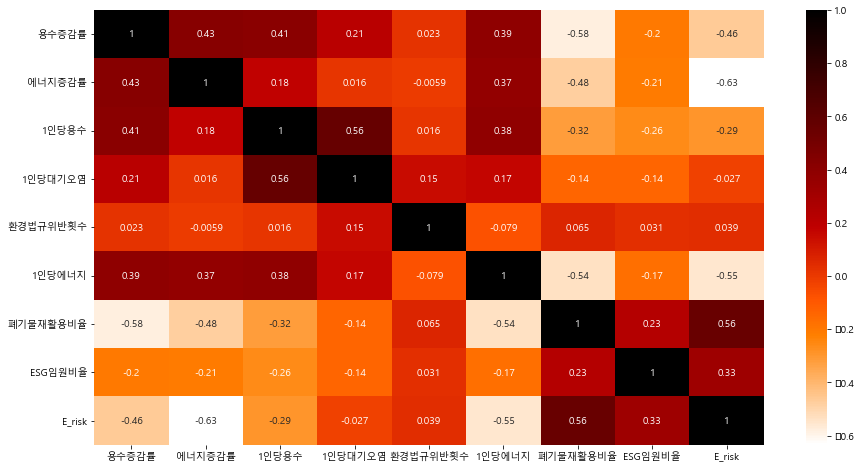

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize = (15,8))
sns.heatmap(x_train[new_num_var].corr(), annot=True,cmap='gist_heat_r')
plt.show()

* 상관계수 plot에서도 특별히 위험한 수준의 상관관계는 없는 것으로 해석할 수 있다. 따라서 train set이 Multinomial Logistic Model을 사용하여 적합 할 수 있고, 그 결과는 신뢰할 수 있다고 말할 수 있다.

## 5. Estimation
- r_test 사용 (scaling 및 dummy 생성 완료된 데이터)

In [33]:
# 추가로 drop할 변수 있으면 drop해주기
x_test = r_test.drop(columns=['종목코드','회사명','SICS_Sector_Kr','E_GRADE','Stratify'], 
                     inplace=False)

# 삭제할 변수 명 입력
x_test.drop(columns=['1인당온실가스', '1인당폐기물', '온실가스증감률', '대기오염증감률', '용수재활용비율', '폐기물증감률'], inplace=True)
x_test = sm.add_constant(x_test, prepend=False)
pred = model.predict(result.params, x_test)
pred = pred.argmax(1) + 1

E_result = copy.deepcopy(r_test)
E_result['pred_grade'] = pred
E_result=E_result[['종목코드','pred_grade']]

In [34]:
# E_result 데이터프레임 확인
E_result.head(5)

,종목코드,pred_grade
0,243070,6
1,298000,4
2,298020,5
3,298050,3
4,298040,2


In [35]:
#E_result 값 저장
E_result.to_csv("E_result.csv", index=False, encoding="utf-8-sig")